<a href="https://colab.research.google.com/github/taristadwi/MachineLearningTarista/blob/main/jobsheet10(ML)_TaristaDwiSilvia_2141720014.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NAMA:Tarista Dwi Silvia**

# **NIM:2141720014**

# **KELAS:TI-3A**

---



---



# **PRAKTIKUM 1**

# RNN untuk Analisis Sentimen

###Setup

Impor matplotlib dan buat fungsi pembantu untuk memplot grafik:

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

###Setup input pipeline

Dataset ulasan film IMDB adalah kumpulan data klasifikasi biner—semua ulasan memiliki sentimen positif atau negatif.
Download dataset menggunakan **TFDS**. Lihat **loading text tutorial** jika ingin me load data secara manual

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Awalnya ini mengembalikan dataset (teks, pasangan label)

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini:

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b"Maybe I'm being too generous with the rating...but I just love this movie! I've seen it so many times, but every time I see it I fall in love with it all over again. It's just a simple romantic comedy, with nothing huge or monumentous that happens. But I'm a big romantic and this movie *is* romantic. I love Meg Ryan and Tim Robbins, and Walter Mathau is so funny. The scientists make me laugh so much...I definitely recommend this movie to anyone who hasn't seen it. It's such a clean, good movie - and those are so rare now! My 20-year-old brother likes this movie, too, so it's not just a chick-flick. ;-) I recommend it if you need to laugh, or if you're just lonely and need to *watch* a romance, if you yourself can't participate in one. It's a good 'un!"
 b"Full Moon High (1981) 3 of 5 Dir: Larry Cohen Stars: Adam Arkin, Ed McMahon, Roz Kelly<br /><br />Tony (Arkin) is your average ordinary high school guy. Prepping for the big homecoming game, girlfriend trouble and growing h

###Buat Teks Encoder

Teks mentah yang dimuat oleh tfds perlu diproses sebelum dapat digunakan dalam model. Cara termudah memproses teks untuk pelatihan adalah menggunakan lapisan TextVectorization. Lapisan ini memiliki banyak kemampuan, namun pada tutorial ini menggunakan perilaku default. Buat lapisan tersebut, dan teruskan teks kumpulan data ke metode .adapt lapisan:

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Metode .adapt mengatur kosakata lapisan. 20 token pertama dapat dilihat dengan kode berikut. Setelah padding dan token yang tidak diketahui, mereka diurutkan berdasarkan frekuensi:

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Setelah kosakata diatur, lapisan dapat mengkodekan teks ke dalam indeks. Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch (kecuali jika Anda menetapkan output_sequence_length tetap):

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[270, 142, 107, ...,   0,   0,   0],
       [371,   1, 322, ...,   0,   0,   0],
       [ 10, 183,  11, ...,   0,   0,   0]])

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"Maybe I'm being too generous with the rating...but I just love this movie! I've seen it so many times, but every time I see it I fall in love with it all over again. It's just a simple romantic comedy, with nothing huge or monumentous that happens. But I'm a big romantic and this movie *is* romantic. I love Meg Ryan and Tim Robbins, and Walter Mathau is so funny. The scientists make me laugh so much...I definitely recommend this movie to anyone who hasn't seen it. It's such a clean, good movie - and those are so rare now! My 20-year-old brother likes this movie, too, so it's not just a chick-flick. ;-) I recommend it if you need to laugh, or if you're just lonely and need to *watch* a romance, if you yourself can't participate in one. It's a good 'un!"
Round-trip:  maybe im being too [UNK] with the [UNK] i just love this movie ive seen it so many times but every time i see it i fall in love with it all over again its just a simple romantic comedy with nothing huge or [UNK]

###Buat Model

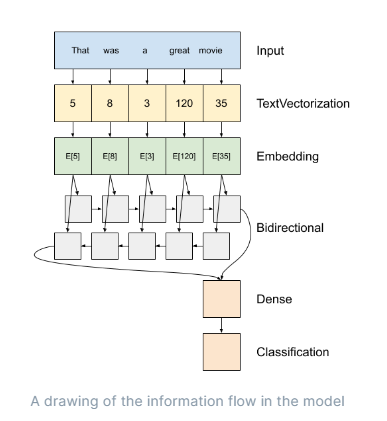

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


Untuk memastikan bahwa ini berfungsi seperti yang diharapkan, evaluasi sebuah kalimat dua kali. Pertama, satu kalimat sehingga tidak ada bantalan (padding) untuk disamarkan:

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[0.00814155]


Sekarang, evaluasi lagi dalam batch dengan kalimat yang lebih panjang. Hasilnya harus sama:

In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 91ms/step
[0.00814155]


compile model Keras untuk mengonfigurasi proses pelatihan:

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

###Train Model

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 43s 89ms/step - loss: 0.6397 - accuracy: 0.5778 - val_loss: 0.5284 - val_accuracy: 0.7198
Epoch 2/10
391/391 [==============================] - 26s 66ms/step - loss: 0.4882 - accuracy: 0.7523 - val_loss: 0.4619 - val_accuracy: 0.8016
Epoch 3/10
391/391 [==============================] - 28s 71ms/step - loss: 0.3887 - accuracy: 0.8257 - val_loss: 0.3812 - val_accuracy: 0.8448
Epoch 4/10
391/391 [==============================] - 26s 65ms/step - loss: 0.3434 - accuracy: 0.8488 - val_loss: 0.3392 - val_accuracy: 0.8568
Epoch 5/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3224 - accuracy: 0.8596 - val_loss: 0.3279 - val_accuracy: 0.8568
Epoch 6/10
391/391 [==============================] - 24s 61ms/step - loss: 0.3142 - accuracy: 0.8645 - val_loss: 0.3277 - val_accuracy: 0.8500
Epoch 7/10
391/391 [==============================] - 24s 61ms/step - loss: 0.3082 - accuracy: 0.8688 - val_loss: 0.3241 - val_accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: ', test_loss)
print('Test Accuracy : ', test_acc)

391/391 [==============================] - 11s 28ms/step - loss: 0.3184 - accuracy: 0.8526
Test Loss:  0.31844455003738403
Test Accuracy :  0.8525999784469604


(0.0, 0.6566410750150681)

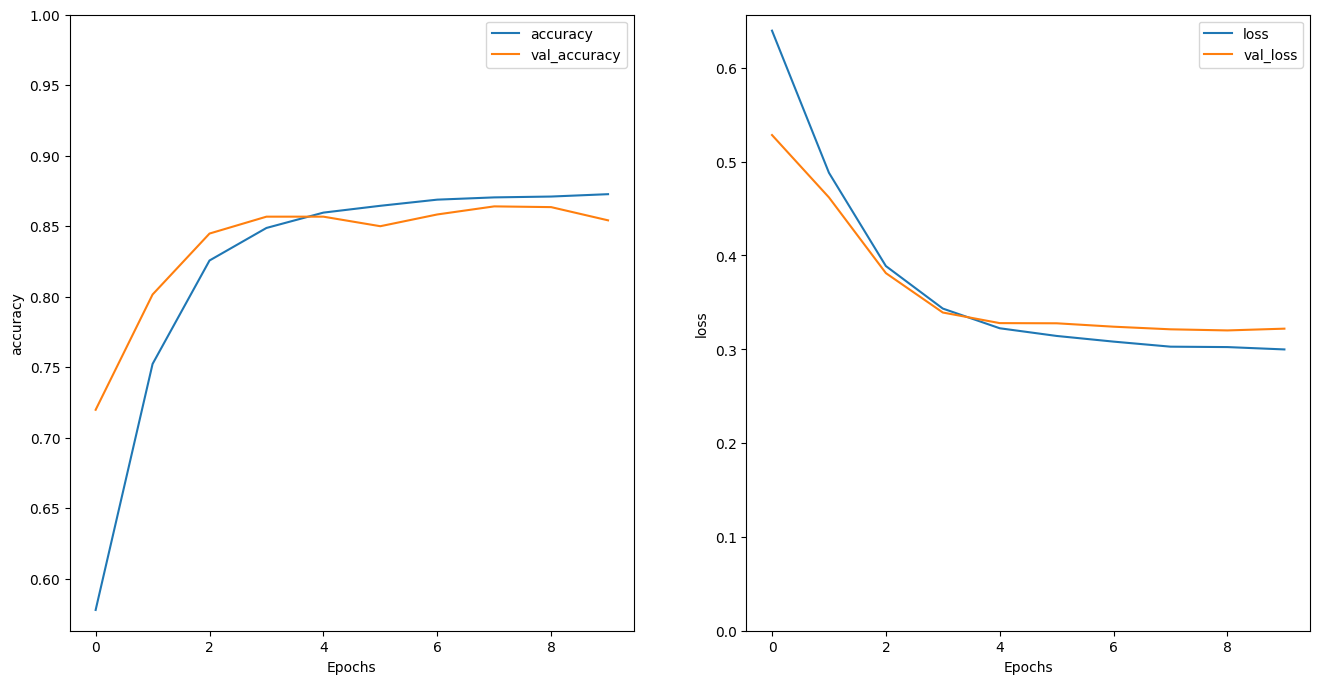

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Jalankan prediksi pada kalimat baru:
Jika prediksi >= 0,0 berarti positif, jika tidak maka negatif.

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics'
                'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


### Stack two or more LSTM layers

Berikut adalah alur informasi dengan return_sequences=True:

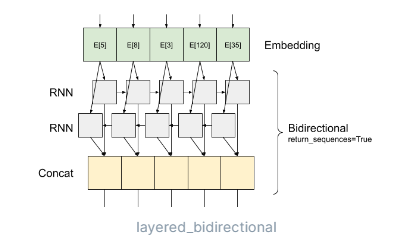

Hal yang menarik dari penggunaan RNN dengan return_sequences=True adalah outputnya masih memiliki 3 axis, sama seperti inputnya, sehingga bisa diteruskan ke layer RNN lain, seperti ini:

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 77s 151ms/step - loss: 0.6541 - accuracy: 0.5564 - val_loss: 0.4684 - val_accuracy: 0.7781
Epoch 2/10
391/391 [==============================] - 47s 120ms/step - loss: 0.4003 - accuracy: 0.8264 - val_loss: 0.3647 - val_accuracy: 0.8281
Epoch 3/10
391/391 [==============================] - 46s 117ms/step - loss: 0.3430 - accuracy: 0.8535 - val_loss: 0.3340 - val_accuracy: 0.8510
Epoch 4/10
391/391 [==============================] - 49s 125ms/step - loss: 0.3313 - accuracy: 0.8578 - val_loss: 0.3309 - val_accuracy: 0.8542
Epoch 5/10
391/391 [==============================] - 45s 116ms/step - loss: 0.3158 - accuracy: 0.8653 - val_loss: 0.3341 - val_accuracy: 0.8552
Epoch 6/10
391/391 [==============================] - 45s 114ms/step - loss: 0.3130 - accuracy: 0.8668 - val_loss: 0.3168 - val_accuracy: 0.8609
Epoch 7/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3110 - accuracy: 0.8671 - val_loss: 0.3206 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 20s 52ms/step - loss: 0.3320 - accuracy: 0.8496
Test Loss: 0.3319918215274811
Test Accuracy: 0.8496000170707703


In [ ]:
# predict on a sample text without padding

sample_text = ('The movie was not good. The animation and the graphics'
                'were terrible. I would not recommend this movie.')

predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 5s 5s/step
[[-1.2936199]]


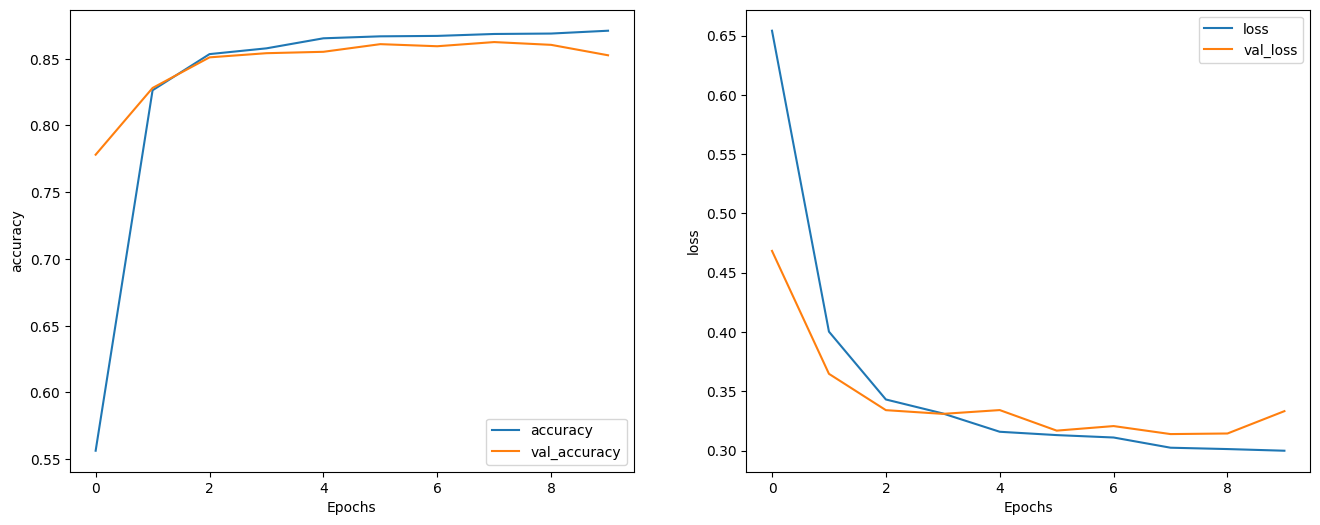

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

#**PRAKTIKUM 2**

# Generator Teks dengan RNN

# Setup

Import TensorFlow

In [ ]:
import tensorflow as tf
import numpy as np
import os
import time

Download Dataset Shakespeare

In [ ]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

Load Data

In [ ]:
# Read, the people decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding = 'utf-8')

# length of text is the number characters in it
print(f'Length of text : {len(text)}characters')

Length of text : 1115394characters


In [ ]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [ ]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


###Olah Teks

Vectorize Teks

Sebelum training, Anda perlu mengonversi string menjadi representasi numerik. tf.keras.layers.StringLookup dapat mengubah setiap karakter menjadi ID numerik. Caranya adalah teks akan dipecah menjadi token terlebih dahulu.

In [ ]:
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

sekarang buat tf.keras.layers.StringLookup layer:

In [ ]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary = list(vocab), mask_token=None
)

perintah diatas mengconvert token menjadi id

In [ ]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

Karena tujuan tutorial ini adalah untuk menghasilkan teks, penting juga untuk membalikkan representasi ini. Untuk ini Anda dapat menggunakan kode tf.keras.layers.StringLookup(..., invert=True).
Catatan: pada kode ini, daripada meneruskan kosakata asli yang dihasilkan dengan diurutkan(set(teks)) gunakan metode get_vocabulary() dari tf.keras.layers.StringLookup sehingga token [UNK] disetel dengan cara yang sama.

In [ ]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary = ids_from_chars.get_vocabulary(),
    invert = True, mask_token = None
)

Lapisan ini mengconvert kembali karakter dari vektor ID, dan mengembalikannya sebagai karakter tf.RaggedTensor:

In [ ]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

Anda dapat menggunakan tf.strings.reduce_join untuk menggabungkan kembali karakter menjadi string.

In [ ]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [ ]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

# Prediksi

Membuat Trianing Set dan Target

In [ ]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [ ]:
for ids in ids_dataset.take(10):
  print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [ ]:
seq_length = 100

Metode batch memungkinkan Anda dengan mudah mengonversi karakter individual ini menjadi urutan ukuran yang diinginkan.

In [ ]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


akan lebih mudah untuk melihat apa yang dilakukan jika Anda menggabungkan token kembali menjadi string:

In [ ]:
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


Berikut adalah fungsi yang mengambil urutan sebagai masukan, menduplikasi, dan menggesernya untuk menyelaraskan masukan dan label untuk setiap langkah waktu:

In [ ]:
def split_input_target(sequence):
  input_text = sequence[:-1]
  target_text = sequence[1:]
  return input_text, target_text

In [ ]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [ ]:
dataset = sequences.map(split_input_target)

In [ ]:
for input_example, target_example in dataset.take(1):
  print("Input :", text_from_ids(input_example).numpy())
  print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


# Membuat Batch Training

Anda menggunakan tf.data untuk membagi teks menjadi sequence yang dapat diatur. Namun sebelum memasukkan data ini ke dalam model, Anda perlu mengacak data dan mengemasnya ke dalam batch.

In [ ]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

###Buat Model

Bagian ini mendefinisikan model sebagai subkelas keras

In [ ]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [ ]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

###Uji Model

pertama, cek bentuk dari output

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


Dalam contoh di atas, panjang urutan masukan adalah 100 tetapi model dapat dijalankan pada masukan dengan panjang berapa pun:

In [ ]:
model.summary()

Model: "my_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    multiple                  16896     
                                                                 
 gru_7 (GRU)                 multiple                  3938304   
                                                                 
 dense_15 (Dense)            multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


mengambil sampel dari distribusi keluaran, untuk mendapatkan indeks karakter aktual. Distribusi ini ditentukan oleh logit pada kosakata karakter.

In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices =  tf.squeeze(sampled_indices, axis=-1).numpy()

Hal ini memberi kita, pada setiap langkah waktu, prediksi indeks karakter berikutnya:

In [ ]:
sampled_indices

array([39, 40, 18,  8, 46, 64, 38,  2, 59,  4, 18, 32, 15, 11, 63, 40,  4,
       50, 49, 48, 27, 57, 63, 35, 25,  6, 28, 59, 33, 25, 34, 36, 57, 33,
       64,  4, 65, 38, 61, 26, 49, 12, 56, 17, 22, 35, 10, 52,  4, 51, 34,
       30, 63, 15, 13, 30, 64, 23, 63, 20,  5, 51, 32, 58, 21, 13,  3, 61,
       33, 38,  1, 17, 65, 27, 36, 31, 46, 26,  1, 30, 64, 12,  0, 46, 14,
        8, 60,  2, 50, 23, 60, 18,  4, 29, 18, 17, 54, 26,  3, 51])

Dekode kode berikut untuk melihat teks yang diprediksi oleh model tidak terlatih ini:

In [ ]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b"lly indeed to all estates,--\nYet whether you accept our suit or no,\nYour brother's son shall never r"

Next Char Predictions:
 b"ZaE-gyY t$ESB:xa$kjiNrxVL'OtTLUWrTy$zYvMj;qDIV3m$lUQxB?QyJxG&lSsH?!vTY\nDzNWRgM\nQy;[UNK]gA-u kJuE$PEDoM!l"


###Train Model

Berdasarkan status RNN sebelumnya, dan masukan langkah kali ini, prediksi kelas karakter berikutnya.

Tambahan optimizer dan fungsi loss

loss function tf.keras.losses.sparse_categorical_crossentropy standar berfungsi dalam kasus ini karena diterapkan di seluruh dimensi terakhir prediksi. Karena model Anda mengembalikan logits, Anda perlu mengatur flag from_logits.

In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.189457, shape=(), dtype=float32)


memeriksa bahwa eksponensial dari loss rata-rata harus kira-kira sama dengan ukuran kosakata. Loss yang jauh lebih tinggi berarti model tersebut yakin akan jawaban yang salah, dan memiliki inisialisasi yang buruk

In [ ]:
tf.exp(example_batch_mean_loss).numpy()

65.986946

Konfigurasikan prosedur pelatihan menggunakan metode tf.keras.Model.compile. Gunakan tf.keras.optimizers.Adam dengan argumen default dan fungsi loss.

In [ ]:
model.compile(optimizer='adam', loss=loss)

**Konfigurasi Checkpoints**

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

**Lakukan Proses Training**

Gunakan tf.keras.callbacks.ModelCheckpoint untuk memastikan bahwa checkpoint disimpan selama pelatihan:

In [ ]:
EPOCHS = 20

In [ ]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 15s 66ms/step - loss: 2.7458
Epoch 2/20
172/172 [==============================] - 14s 62ms/step - loss: 1.9999
Epoch 3/20
172/172 [==============================] - 13s 62ms/step - loss: 1.7270
Epoch 4/20
172/172 [==============================] - 14s 61ms/step - loss: 1.5657
Epoch 5/20
172/172 [==============================] - 12s 61ms/step - loss: 1.4645
Epoch 6/20
172/172 [==============================] - 12s 62ms/step - loss: 1.3963
Epoch 7/20
172/172 [==============================] - 12s 62ms/step - loss: 1.3430
Epoch 8/20
172/172 [==============================] - 12s 62ms/step - loss: 1.2980
Epoch 9/20
172/172 [==============================] - 12s 62ms/step - loss: 1.2569
Epoch 10/20
172/172 [==============================] - 12s 61ms/step - loss: 1.2181
Epoch 11/20
172/172 [==============================] - 12s 62ms/step - loss: 1.1792
Epoch 12/20
172/172 [==============================] - 12s 62ms/step - loss: 1.1398
E

###Generate Teks

Cara termudah untuk menghasilkan teks dengan model ini adalah dengan menjalankannya dalam loop, dan menyimpan status internal model saat Anda menjalankannya.

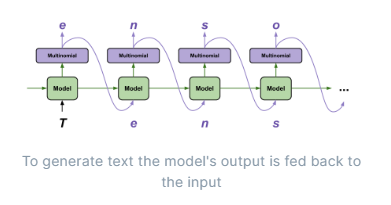

Berikut ini membuat prediksi satu langkah:

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [ ]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

Jalankan secara berulang untuk menghasilkan beberapa teks. Melihat teks yang dihasilkan, Anda akan melihat model mengetahui kapan harus menggunakan huruf besar, membuat paragraf, dan meniru kosakata menulis seperti Shakespeare. Karena sedikitnya jumlah epoch pelatihan, model belum belajar membentuk kalimat runtut.

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
Do you between us!

ALO:
Stupper!

HERMIONE:
What?
'Twas by nimble home, sir parson?

Messenger:
Yes, and my lord, it should be whipp'd in such
anvocated stole? Buy follow'st think, is soonest please,
I am deorled and still resign his curses.
And how he found'st a kind tumbling thread?

PARIS:
You mistake, some harl; so were you so he hear hithers
Made hig adoked and such a swelling grieving
Mad what is hither have all unponsent,
To say 'Will then the benefit there was a wive
Equal scorn, with Geopla use,
When I shall sloy your brother, God ye gods,
In lamenyable breast whereop, Kate,
Rather thank me on the villain's death.
Had the very day she hangs upon me.

KING EDWARD IV:
Thy mother had a banish'd men of vast, and he is writ
Shall fight in secret please to hide receives,
And do it early beautio; and thou hast verrect me,
who, if you lay would be on a lord, wherein
You will not come from forth, consul!

First Servingman:
For he is call'd for's partine.

RICHARD:
ANGersonacle,

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nNow too make hearts may compeased.\n\nESCALUS:\nGoodly, sir, this lady mooder hows:\nGreat king indeed in a truth earth,\nThat he needs dising it, 'tis well.\n'Tis for the forest wife for Even when\nI say to perceive my mind.\nThese tastes--for her people break your hope,\nVitting our harm in sighs and ease the heavensure\nTo execute the child, has found me not,\nThat raised unto them all condement, love,\nAnd he will bear the swords of that kissess\nDin realment to yourself.\n\nMIRANDA:\nI know not. I saw her and his cut most liking\npenulty.\n\nCAMILLO:\nShe presents!\nIs, that my sovereign liege approve.\nShe is but from my neck, and little brow:\nAnd so shall shearted with this king about!\n\nJULIET:\nGone man! what's the very price that way\n're still'd and will not pass.\n\nFLORIZEL:\nThis was a good day's roy!\n\nPAULINA:\nI am glad or born,\nMaking him by the friends the party trial:\nAnd as the rarityment teems unloads\nmine honour, none but fools the fri

###Ekspor Model Generator

Model satu langkah ini dapat dengan mudah disimpan dan digunakan kembali, memungkinkan Anda menggunakannya di mana pun tf.saved_model diterima.

In [ ]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [ ]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
Blister us batf conserers in my mind;
The loss of staturel, and fert it,
One of our honour knows, y


# **TUGAS PRAKTIKUM**

1. Jalankan Model dan hitung loss dengan tf.GradientTape.
2. Hitung update dan terapkan pada model dengan optimizer

In [ ]:
class CustomTraining(MyModel):
 @tf.function
 def train_step(self, inputs):
      inputs, labels = inputs
      with tf.GradientTape() as tape:
        predictions = self(inputs, training=True)
        loss = self.loss(labels, predictions)
      grads = tape.gradient(loss, model.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

      return {'loss': loss}

Kode diatas menerapkan train_step method sesuai dengan  Keras' train_step conventions. Ini opsional, tetapi memungkinkan Anda mengubah perilaku langkah pelatihan dan tetap menggunakan keras Model.compile and Model.fit methods.

In [ ]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [ ]:
model.fit(dataset, epochs=1)

172/172 [==============================] - 16s 63ms/step - loss: 2.7348


Atau jika ingin lebih mengetahui dalamnya, kita bisa membuat custom training loop sendiri:

In [ ]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
    start = time.time()

    mean.reset_states()
    for (batch_n, (inp, target)) in enumerate(dataset):
      logs = model.train_step([inp, target])
      mean.update_state(logs['loss'])

      if batch_n % 50 == 0:
         template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
         print(template)

 # saving (checkpoint) the model every 5 epochs
      if (epoch + 1) % 5 == 0:
         model.save_weights(checkpoint_prefix.format(epoch=epoch))

    print()
    print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
    print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 2.1919
Epoch 1 Batch 50 Loss 2.0572
Epoch 1 Batch 100 Loss 1.9486
Epoch 1 Batch 150 Loss 1.8605

Epoch 1 Loss: 2.0002
Time taken for 1 epoch 13.45 sec
________________________________________________________________________________
Epoch 2 Batch 0 Loss 1.8112
Epoch 2 Batch 50 Loss 1.8218
Epoch 2 Batch 100 Loss 1.7476
Epoch 2 Batch 150 Loss 1.6371

Epoch 2 Loss: 1.7173
Time taken for 1 epoch 12.27 sec
________________________________________________________________________________
Epoch 3 Batch 0 Loss 1.5860
Epoch 3 Batch 50 Loss 1.5454
Epoch 3 Batch 100 Loss 1.5495
Epoch 3 Batch 150 Loss 1.5537

Epoch 3 Loss: 1.5521
Time taken for 1 epoch 12.19 sec
________________________________________________________________________________
Epoch 4 Batch 0 Loss 1.4577
Epoch 4 Batch 50 Loss 1.4496
Epoch 4 Batch 100 Loss 1.4229
Epoch 4 Batch 150 Loss 1.4151

Epoch 4 Loss: 1.4515
Time taken for 1 epoch 11.81 sec
_____________________________________________________________________